In [1]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize" ] = [20, 16]
input_length=14#koliko dni do danes dobimo podatke?
output_distance=7#za koliko dni vnaprej moramo napovedati stanje?
sample_length=input_length+output_distance

Poberemo podatke o številu okužb po dnevih

In [2]:
path="./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df=pd.read_csv(path)
width=len(df.columns)-4 #Širina časovnega zaporedja
height=len(df)
df.head(50)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,10,14,16,17,19,19,19,19,19,19
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,15,15,15,19,19,19,19,21,21,23
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,1451,1451,1554,1628,1715,1795,1975,1975,2142,2208
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,770,822,833,853,881,921,937,967,1013,1039
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,93,96,96,96,99,100,103,103,103,102
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863


Iz teh podatkov naredimo seznam časovnih vrst. 

In [42]:
import geonamescache
from geonamescache.mappers import country

gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
mapper = country(from_key='name', to_key='iso')
#print(countries)
series=[]
names=[]
population=[]
for row in range(height):
    data=[]
    if len(str(df["Province/State"][row]))>3:
        #print(df["Province/State"][row])
        continue
    for col in range(4,len(df.columns)):
        data.append(df[df.columns[col]][row]) 
    if(mapper(df["Country/Region"][row])!=None):
        series.append(data)
        names.append(df["Country/Region"][row])
        #print(str(names[-1])+" "+str(mapper(names[-1])))
        population.append(countries[mapper(names[-1])]["population"])
    else:
       #print(df["Country/Region"][row])
        pass
#for i in range(len(names)):
    #print(str(names[i])+" "+str(population[i]))
#print(str(series).replace("[","{").replace("]","}"))

Afghanistan 29121286
Albania 2986952
Algeria 34586184
Andorra 84000
Angola 13068161
Antigua and Barbuda 86754
Argentina 41343201
Armenia 2968000
Austria 8205000
Azerbaijan 8303512
Bahamas 301790
Bahrain 738004
Bangladesh 156118464
Barbados 285653
Belarus 9685000
Belgium 10403000
Benin 9056010
Bhutan 699847
Bolivia 9947418
Bosnia and Herzegovina 4590000
Brazil 201103330
Brunei 395027
Bulgaria 7148785
Burkina Faso 16241811
Cabo Verde 508659
Cambodia 14453680
Cameroon 19294149
Central African Republic 4844927
Chad 10543464
Chile 16746491
Colombia 47790000
Costa Rica 4516220
Cote d'Ivoire 21058798
Croatia 4284889
Cuba 11423000
Cyprus 1102677
Czechia 10476000
Denmark 5484000
Djibouti 740528
Dominican Republic 9823821
Ecuador 14790608
Egypt 80471869
El Salvador 6052064
Equatorial Guinea 1014999
Eritrea 5792984
Estonia 1291170
Eswatini 1354051
Ethiopia 88013491
Fiji 875983
Finland 5244000
France 64768389
Gabon 1545255
Gambia 1593256
Georgia 4630000
Germany 81802257
Ghana 24339838
Greece 11000

Vzamemo neko funkcijo za napako ki je odporna na b=0, ampak vseeno rajši aproksimira relativno napako, ker nas ta precej bolj zanima

In [4]:
def err(x,a):
    return (x-a)**2

Napišemo si funkcijo ki oceni nek (model?) algoritem.

In [43]:
class Data_segment:
    def __init__(self,input_list,name,population):
        assert len(input_list)==sample_length
        self.input=input_list[0:input_length]
        self.output=input_list[-1]
        self.raw=input_list[:]
        self.name=name
        self.population=population

In [60]:
def input_generator():
    inputs=[]
    for row in range(len(series)):
        for c in range(len(series[row])-sample_length):
            if series[row][c]>50:#Vsaj 50 okužb da začnemo analizirati podatke
                list=series[row][c:c+sample_length]
                inputs.append(Data_segment(list,names[row],population[row]))
                #print(row)
    return inputs

In [61]:
def evaluate(prediction):
    err_sum=0#vsota relativnih napak
    tries=len(inputs)
    for input in inputs:
        response=prediction(input.input,input.population)
        correct=input.output
        error=err(response,correct)
        #print(str(input.input)+" "+str(response)+" "+str(input.ans)+" "+str(error))
        err_sum+=error
    return (err_sum/tries)/(10**6)

In [62]:
inputs=input_generator()
print(len(inputs))
print(inputs[0].raw)
print(inputs[0].input)
print(inputs[0].output)
print(inputs[0].name)
print(inputs[0].population)

1077
[51, 55, 59, 64, 70, 76, 89, 104, 123, 146, 174, 186, 197, 212, 223, 243, 259, 277, 304, 333, 361]
[51, 55, 59, 64, 70, 76, 89, 104, 123, 146, 174, 186, 197, 212]
361
Albania
2986952


Prvi poskus: število okužb jutri bo 0. To bi moralo dati slab rezultat

In [63]:
def return_healthy_for_sure(ls,population):
    return 0
print(evaluate(return_healthy_for_sure))

2844.76447288208


Verjetno je precej boljša ideja da vrnemo število okuženih včeraj. Vsaj spodnja meja se ujema...

In [64]:
def return_yesterday(ls,population):
    return ls[-1]
print(evaluate(return_yesterday))

TypeError: return_yesterday() takes 1 positional argument but 2 were given

Kot kaže je uporaba malo logike precej boljša. Kdo bi si mislil. Sedaj naredimo interpolacijo iz enega dneva nazaj v "output_distance" dni naprej

In [49]:
def small_interpolation(ls,population):
    return ls[-1]+output_distance*(ls[-1]-ls[-2])*0.4
print(evaluate(small_interpolation))

305.66167026677795


Poskusimo s pomočjo razmerij

In [50]:
def ratio_interpolation(ls,population):
    return ls[-1]*(ls[-1]/ls[-2])**(output_distance*0.2)
print(evaluate(ratio_interpolation))

428.39874000940114


Glede na uteži ki smo jih morali dodati da je bil rezultat vsaj približno dober, smo verjetno bistveno divergirali od željenih vrednosti zaradi interpolacije v toliko dni naprej. Poskusimo uporabiti linearno interpolacijo z utežmi

In [94]:
def generate_fit_from_weights_linear(w):
    def linear_weight_interpolation(ls,population):
        weightedTerms=[w[i]*ls[-1-i] for i in range(len(w))]
        return sum(weightedTerms)
    
    return linear_weight_interpolation

def generate_good_linear_interpolation():
    weights=[0 for i in range(input_length)]#Recimo [0,0,0,0] da prvo funkcijo ki vedno vrne 0, [1,0,0,0] pa da funckijo ki gleda včeraj
    best=evaluate(generate_fit_from_weights_linear(weights))
    #print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(1000): 
        if(i%100==0):
            print(i)
        while(True):
            p=random.randrange(len(weights))
            if p in [0,1,2,4,7,10,13]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                break
        change=w*(random.random()-0.5)
        weights[p]+=change
        curr=evaluate(generate_fit_from_weights_linear(weights))
        #print(str(weights)+" "+str(curr))
        if(curr<best):
            best=curr
            if i-last>30:
                last=i
                #print(curr)
                #print(weights)
        else:
            weights[p]-=change
    print(best)
    print(weights)
    return generate_fit_from_weights_linear(weights)
    
good_linear_interpolation=generate_good_linear_interpolation()

0
100
200
300
400
500
600
700
800
900
88.44741296306138
[1.2083989304644882, 0.8423705778522224, 0.33273699708646304, 0, 0.46122686343158853, 0, 0, -0.29312088583019175, 0, 0, -1.9942272967538544, 0, 0, -0.8033177027317564]


To nam da nekje 3 krat boljši rezultat. Poskusimo narisati kaj naš algoritem izračuna

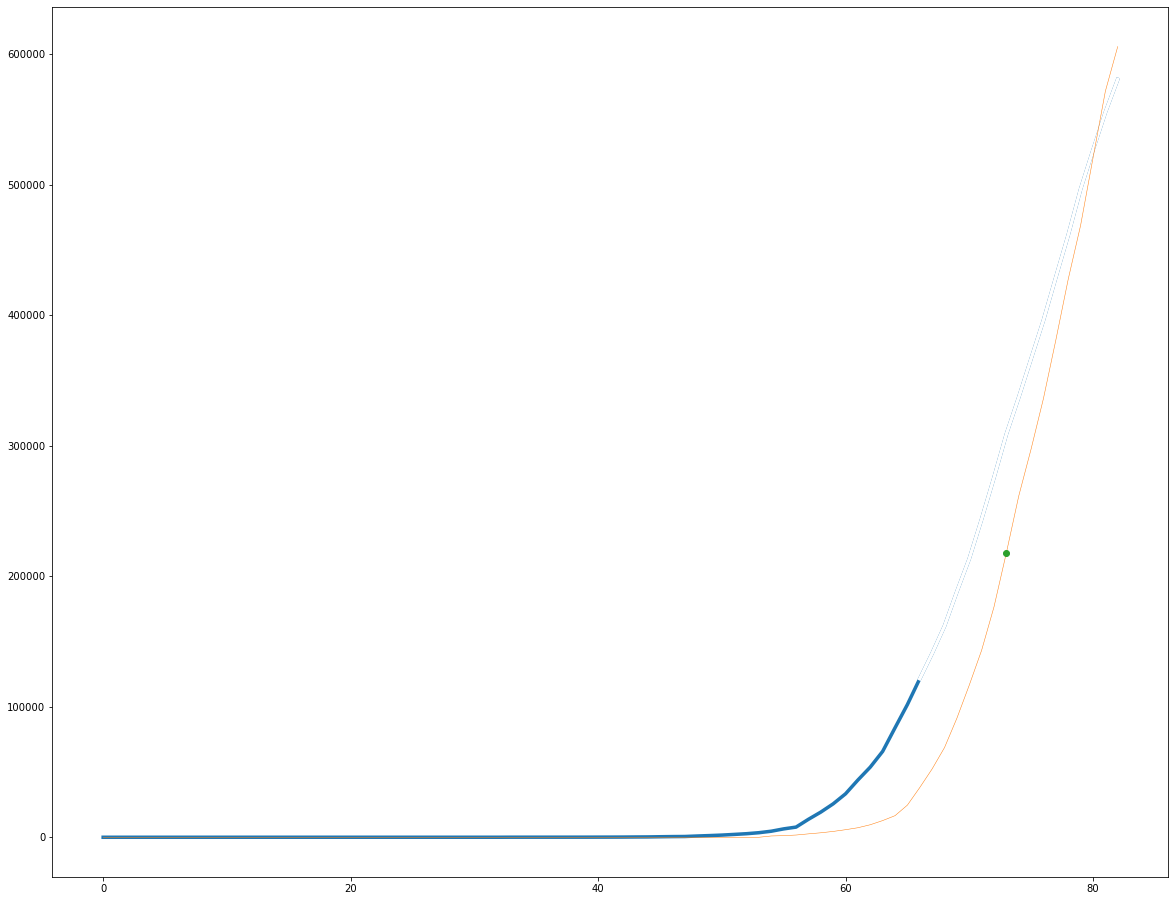

<function __main__.update(shift=10)>

In [118]:
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import *
import numpy.ma as ma
while(True):
    pos=random.randrange(len(series))
    row=series[pos]
    if(row[-sample_length-10]>50):
        print(pos)
        print(names[pos])
        break

print(row)
print(population[pos])
shift=0
def update(shift=10):

    x=np.arange(0, len(row), 1);
    y=[]
    lin_p=[]
    #exp_p=[]
    for i in range(len(row)):
        y.append(row[i])

    p=0
    while(p<len(row)):
        if p<sample_length or row[p-sample_length]<50:
            lin_p.append(0)
        else:
            lin_p.append(good_linear_interpolation2(y[p-sample_length:p-output_distance],population[pos]))
        p+=1

    #p=0
    #while(p<len(row)):
    #    if p<sample_length or row[p-sample_length]<50:
    #        exp_p.append(0)
    #    else:
    #        exp_p.append(log_weight_interpolation(y[p-sample_length:p-output_distance]))
    #    p+=1

    #errors_lin=[err(lin_p[i],y[i]) for i in range(len(row))]
    #errors_exp=[err(exp_p[i],y[i]) for i in range(len(row))]
    
    
    layerdict = dict()
    layerdict["Xc"] = x
    layerdict["Yc"] = y

    highlightmask = np.ones(len(layerdict['Xc'])).astype(bool)
    highlightmask[-output_distance-shift:] = False

    layerdict['Xc'] = ma.array(layerdict['Xc'])
    layerdict['Yc'] = ma.array(layerdict['Yc'], mask=highlightmask)

    plt.plot(layerdict['Xc'], layerdict['Yc'].data, label='linepath', linewidth=3.5)
    plt.plot(layerdict['Xc'], layerdict['Yc'], 'w', linewidth=3.5)
    
    layerdict2 = dict()
    layerdict2["Xc"] = x
    layerdict2["Yc"] = lin_p

    highlightmask2 = np.ones(len(layerdict2['Xc'])).astype(bool)
    highlightmask2[-shift:-shift+1] = False

    layerdict2['Xc'] = ma.array(layerdict2['Xc'])
    layerdict2['Yc'] = ma.array(layerdict2['Yc'], mask=highlightmask2)
    
    plt.plot(layerdict2['Xc'], layerdict2['Yc'].data, label='linepath', linewidth=.5)
    plt.plot(layerdict2['Xc'], layerdict2['Yc'], 'o', linewidth=3.5)
    plt.show()

interact(update, shift = widgets.IntSlider(value=10, min=0, max=80, step=1))

Poskusimo interpolirati logaritem funkcije iz logaritma podatkov. Potem računamo exp da dobimo nazaj v predvideni obliki

In [53]:
from math import *
def generate_fit_from_weights_exp(w):
    def exp_weight_interpolation(ls,population):
        weightedTerms=[w[i]*log(ls[-1-i]) for i in range(len(w))]
        return exp(sum(weightedTerms))
    
    return exp_weight_interpolation

def generate_good_exp_interpolation():
    weights=[0 for i in range(input_length)]
    best=evaluate(generate_fit_from_weights_exp(weights))
    print(best)
    last=0
    w=0.2#velikost "povprečne" spremembe
    for i in range(1000): 
        if(i%100==0):
            print(i)
        p=random.randrange(len(weights))
        change=w*(random.random()-0.5)
        weights[p]+=change
        curr=evaluate(generate_fit_from_weights_exp(weights))
        #print(str(weights)+" "+str(curr))
        if(curr<best):
            best=curr
            if i-last>30:
                last=i
                print(curr)
                #print(weights)
        else:
            weights[p]-=change
    print(best)
    print(weights)
    return generate_fit_from_weights_exp(weights)
    
exp_inter=generate_good_exp_interpolation()

2844.727528415042
0
673.5015963439829
100
200
673.5001738195396
300
400
670.3878390516932
669.7789596402945
500
600
667.4200442558575
700
800
900
667.4200442558575
[0.15138253874567065, 0.15707044820759236, 0.02221417900523578, 0.002394484765489008, 0.1858283575002614, 0.0, 0.24654534883541582, 0.0002621795661745807, 0.0, 0.06866407680646636, 0.10490026361667115, 0.07955894799273415, 0.03775373248319813, 0.04307089311853591]


To je očitno precej slab postopek za interpolacijo. Napaka je 10 krat večja kot pri linearni interpolaciji. Ideja: ALi obstaja korelacija med tem ali linearna korelacija predvidi preveliko/premajhno število, in med odstotkom okuženih ljudi

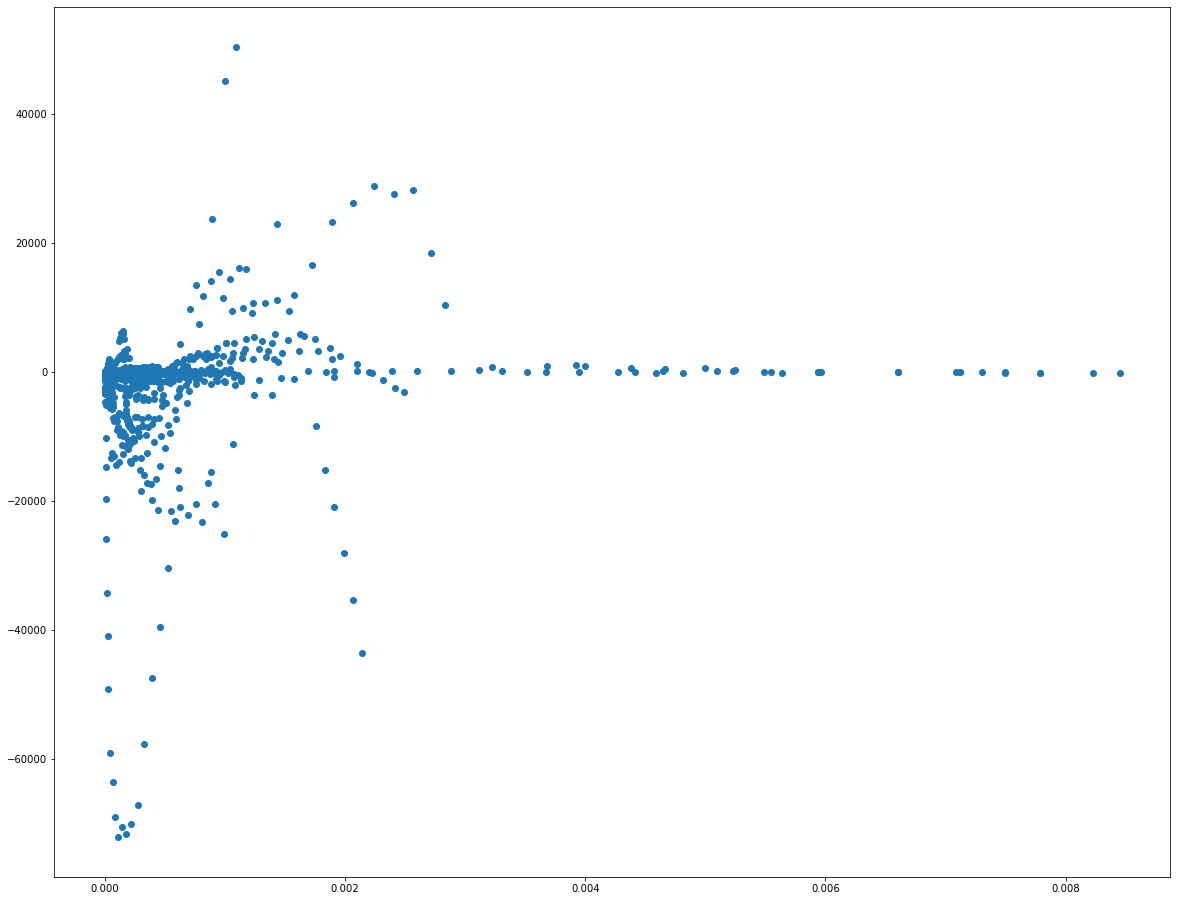

In [105]:
infection_per_million=[]
error=[]
for input in inputs:
    guess=good_linear_interpolation2(input.input,input.population)
    real=input.output
    infection_per_million.append(input.input[-1]/input.population)
    error.append(guess-real)
plt.plot(infection_per_million,error, 'o',)
plt.show()

Iz grafa ni razvidna neka korelacija. Poskusimo vseeno dodati nek faktor ki bo oblike 1/(a+b*odstotek_okuženih) ker morda pričakujemo da z naraščanjem števila okužb, narašča tudi količina ukrepov, ki jih država sprejema za zajezitev epidemije.

In [102]:
def generate_fit_from_weights_linear_afine_infection_percentage(w,w2):
    def linear_weight_interpolation_afine_infection(ls,population):
        weightedTerms=[w[i]*ls[-1-i] for i in range(len(w))]
        return sum(weightedTerms)/(w2[0]+w2[1]*(ls[-1]/population))
    
    return linear_weight_interpolation_afine_infection

def generate_good_linear_interpolation_with_afine_infection_percentage():
    weights=[0 for i in range(input_length)]#Recimo [0,0,0,0] da prvo funkcijo ki vedno vrne 0, [1,0,0,0] pa da funckijo ki gleda včeraj
    weights2=[1,-0.2]#(/(1+0*odstotek_okuženih))
    best=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2))
    print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(2000): 
        if(i%100==0):
            print(i)
        if(random.random()<0.8):
            while(True):
                p=random.randrange(len(weights))
                if p in [0,1,2,4,7,10,13]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                    break
            change=w*(random.random()-0.5)
            weights[p]+=change
            curr=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2,))
            #print(str(weights)+" "+str(curr))
            if(curr<best):
                best=curr
                if i-last>30:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights[p]-=change
        else:
            
            p=random.randrange(2)
            change=w*(random.random()-0.5)
            weights2[p]+=change
            #print(weights2)
            #print(str(weights)+" "+str(curr))
            curr=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2,))
            if(curr<best):
                best=curr
                if i-last>150:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights2[p]-=change
        
    print(best)
    print(weights)
    print(weights2)
    return generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2)
    
good_linear_interpolation2=generate_good_linear_interpolation_with_afine_infection_percentage()

2844.76447288208
0
776.9234867824265
[0.04023852559379537, 0.2300434278464265, 0, 0, 0.4692609719744699, 0, 0, 0.6343695406995828, 0, 0, 0.2265930199576932, 0, 0, 0.3901174368851622] [0.865930596918858, -0.5002790991132207]
396.9708591379419
[0.15837665569398857, 0.5977545494906011, 0.10600363610729602, 0, 0.5341561686991994, 0, 0, 0.8087467043313934, 0, 0, -0.34497392413729655, 0, 0, 0.5475282751375595] [0.8710214102012628, -0.07084089087580647]
100
272.089545323253
[0.2852088451121106, 0.7342882490981824, 0.2125614399165452, 0, 0.38817830694693517, 0, 0, 0.1426498529271646, 0, 0, -0.34497392413729655, 0, 0, 0.19951046945559253] [0.8710214102012628, 0.06471191054295816]
201.1650647749741
[0.48823084373381187, 0.7342882490981824, 0.2125614399165452, 0, 0.38817830694693517, 0, 0, -0.04908187496986294, 0, 0, -0.5373103702370425, 0, 0, 0.034394557165347506] [0.8710214102012628, 0.06471191054295816]
162.30483658317812
[0.4911493592711191, 0.8129733016824487, -0.03411901207531304, 0, 0.3881

Izgleda kot da algoritmu pomaga da malo zniža oceno, če je precejšen odstotek prebivalstva že okužen, kar nekako sledi pričakovanjem. Napaka je sicer padla za morda 10-15%. Dodamo še en fallback, če opazimo da je algoritem očitno naredil neumnost. 

In [126]:
def linear_with_fallback(ls,population):
    expected=good_linear_interpolation2(ls,population)
    if expected<=ls[-1]:#Če vrne da bo čez 7 dni manj primerov kot jih je danes, se to popravi 
        return ls[-1]
    else:
        return expected
    
evaluate(linear_with_fallback)

77.21008096631475

To izboljša rezultat za kakšna 2%. No tudi to je nekaj. 